# North Korea Population, Agriculture and Economy: 1970-2000 

### Team Quetelet Group Members:
#### Saraya Danielsen, Daysha Patalot, Maxwell Sapp (Manager), Hannah Thompson
We collaborated using the following tools:
* Discord for out-of-class communication
* Google Docs for brief project brainstorming and research
* Github for project coding collaboration and data exploration

### Data from the World Bank:
#### The World Development Indicators & `wbdata`
The World Bank maintains a large set of &ldquo;World Development Indicators&rdquo; (WDI),
including information on population.  

-   API for WDI is available at [https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-about-the-indicators-api-documentation](https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-about-the-indicators-api-documentation)

-   A `python` module that uses the API is `wbdata`, written by Oliver Sherouse.

-   Available at [http://github.com/OliverSherouse/wbdata](http://github.com/OliverSherouse/wbdata).


### Project Abstract

Our team is using World Bank Data to explore population dynamics of North Korea over the 3 decade period of 1970 - 2000. We will explore a few significant events in areas such as economic policies and agricultural events that contributed to the observed dynamic explosive shifts of populations between rural and urban classes over this time period due to hard pushes of industrialized development. This large emphasis on industrialization pulled focus away from generating agricultural independence and proved that this industry was susceptible to failure when consecutive climate related events in the 1990s lead to national challenges of insufficient food production and widespread famine that resulted in 100s of thousands of lost lives and malnourished growth development.


#### Our project exploratory research goals included:
* Investigate when the urban population began substantially surpassing the rural population in 1970 in responses to the economic industrialization policies implemented through these decades. 
* How the nations population tripled during this time period, and how combinations of these factors led to food shortages and nationwide famine in the 1990s as a result of weather events and government policy.





In [39]:
"""
If necessary, uncomment and install:
"""
#!pip install wbdata
#!pip install cufflinks


import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cufflinks as cf
cf.go_offline()
import plotly.offline as py
import plotly.graph_objs as go

## [A] Population Statistic Function

It's a long function, but it is incredibly specific; you can estimate any combination of ages, including a single age. It can do much more than just capture the already-established bins. It creates corresponding ratios when an age lands somewhere in the middle of a bin.

###### `population()`


In [2]:
def population(country, year, sex, lower_age, upper_age):
    '''Function returns a SINGLE computed statistic given all the variables.'''
    # 'sex' inputs as either 'All' (for 'All people'), or 'Male' or 'Female'
    
    def build_year_labelled_df(variable_labels, year, country):
        '''Creates a dataframe with 1 or multiple needed labels, so that it can be called in a variety of situations below.'''
        df = wbdata.get_dataframe(variable_labels)
        df = wbdata.get_dataframe(variable_labels, country=country)
        df.reset_index(inplace=True)
        df['date'] = df['date'].astype(int)
        df.set_index(['date'], inplace=True)
        df_with_year = df.query('date==@year')
        return df_with_year
    
    
    variable_labels = {}
    
    # Edge case: not working with age bins, just total population or total male/female population (which have different labels than age bins)
    if lower_age==0 and upper_age>=80:
        if sex=="All":
            variable_labels["SP.POP.TOTL"] = "Total Population"
        elif sex=="Male":
            variable_labels["SP.POP.TOTL.MA.IN"] = "Total Male Population"
        elif sex=="Female":
            variable_labels["SP.POP.TOTL.FE.IN"] = "Total Female Population"
        return build_year_labelled_df(variable_labels, year=year, country=country)[list(variable_labels.values())[0]].iloc[0]
    
    
    # Everything below works with age bins 
    
    # First round up/round down the age boundaries so that all necessary bins will be included
    # (The fraction will be multiplied to get a corresponding smaller ratio of an age-bracket population)
    lower_age_rounded = lower_age
    lower_fraction = 0
    if lower_age%5 != 0:
        if lower_age%5 == 4:
            lower_age_rounded = lower_age - 4
            lower_fraction = (1/5)
        elif lower_age%5 == 3:
            lower_age_rounded = lower_age - 3
            lower_fraction = (2/5)
        elif lower_age%5 == 2:
            lower_age_rounded = lower_age - 2
            lower_fraction = (3/5)
        elif lower_age%5 == 1:
            lower_age_rounded = lower_age - 1
            lower_fraction = (4/5)
    upper_age_rounded = upper_age
    upper_fraction = 0
    if upper_age%5 != 4:
        if upper_age%5 == 3:
            upper_age_rounded = upper_age + 1
            upper_fraction = (4/5)
        elif upper_age%5 == 2:
            upper_age_rounded = upper_age + 2
            upper_fraction = (3/5)
        elif upper_age%5 == 1:
            upper_age_rounded = upper_age + 3
            upper_fraction = (2/5)
        elif upper_age%5 == 0:
            upper_age_rounded = upper_age + 4
            upper_fraction = (1/5)
    
    
    # Get the labels ONLY for the bins that YOU NEED, using a loop that adds to a dictionary as you go
    placehold = lower_age_rounded
    
    def digit_adjust(placehold):
        '''Function that will prepare ages to be used to make variable_labels; turns an int to a string, and reformats single-digit numbers.'''
        if placehold < 10:
            return str(0)+str(placehold)
        else:
            return str(placehold)
    
    
    while placehold <= upper_age_rounded:
        # For all ages before the final age bins:
        while placehold < 80:
            if sex=="All":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".MA"] = str(placehold)+"-"+str(placehold+4)+" Male"
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".FE"] = str(placehold)+"-"+str(placehold+4)+" Female"
            elif sex=="Male":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".MA"] = str(placehold)+"-"+str(placehold+4)+" "+sex
            elif sex=="Female":
                variable_labels["SP.POP."+digit_adjust(placehold)+digit_adjust(placehold+4)+".FE"] = str(placehold)+"-"+str(placehold+4)+" "+sex
            placehold += 5
            
            # If/when the loop reaches the final age bracket, add it in and then stop adding labels
            if placehold >= 80:
                if sex=="All":
                    variable_labels["SP.POP.80UP.MA"] = "80+ Male"
                    variable_labels["SP.POP.80UP.FE"] = "80+ Female"
                elif sex=="Male":
                    variable_labels["SP.POP.80UP.MA"] = "80+ Male"
                elif sex=="Female":
                    variable_labels["SP.POP.80UP.FE"] = "80+ Female"
            break
            
            
    # Now you have a 'variable_labels' that is filled with every label you need; compute final calculations:
    final_df = build_year_labelled_df(variable_labels, year=year, country=country)
    bin_count = len(list(variable_labels.keys()))
    added = 0
    i = 0
    
    
    # Edge case: if you're working with LESS THAN ONE AGE BIN
    # (1) For when the ages are different, but smaller than a single age bin (ex: 3-4 year olds)
    age_difference = upper_age - lower_age
    if age_difference<4 and bin_count==2 and sex=='All': 
        fraction = (age_difference + 1)/5
        while i < bin_count:
            added += (fraction*final_df.iloc[:, i].tolist()[0])
            i+=1
    if age_difference<4 and bin_count==1 and (sex=='Male' or sex=='Female'): 
        fraction = (age_difference + 1)/5
        return np.round(fraction * final_df.iloc[:, 0].tolist()[0])
    
    # (2) For when you're working with a single age (ex: 3-year-olds)
    if lower_age == upper_age:
        fraction = (1/5)
        if sex=="All":
            while i < 2:
                added += (fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        else:
            return np.round(fraction * final_df.sum(axis=1).tolist()[0])
    
    
    
    # FINAL OUTPUTS FOR 1 OR MORE AGE BINS: (4 different variations of cases)
    
    # CASE 1: If no rounding was needed (perfect bins):
    if lower_age%5==0 and upper_age%5==4:
        return final_df.sum(axis=1).tolist()[0]
        
        
    # CASE 2: If lower_age was rounded and upper_age wasn't:
    elif lower_age%5!=0 and upper_age%5==4:
        # For sex="All", TWO COLUMNS will need to be adjusted (Male AND Female)
        if sex=="All":
            while i < bin_count:
                while i < 2:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                added += final_df.iloc[:, i].tolist()[0]
                i+=1
        else:
            while i < bin_count:
                while i < 1:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                added += final_df.iloc[:, i].tolist()[0]
                i+=1
            
    
    # CASE 3: If upper_age was rounded and lower_age wasn't:
    elif lower_age%5==0 and upper_age%5!=4:
        if sex=="All":
            while i < bin_count:
                while i < (bin_count - 2):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
            return np.round(added)
        else:
            while i < bin_count:
                while i < (bin_count - 1):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        
            
    # CASE 4: If both upper_age and lower_age were rounded:
    else:
        if sex=="All":
            while i < bin_count:
                while i < 2:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                while i>1 and i<(bin_count - 2):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1
        else:
            while i < bin_count:
                while i < 1:
                    added += (lower_fraction*final_df.iloc[:, i].tolist()[0])
                    i+=1
                while i>0 and i<(bin_count - 1):
                    added += final_df.iloc[:, i].tolist()[0]
                    i+=1
                added += (upper_fraction*final_df.iloc[:, i].tolist()[0])
                i+=1 
                
                
    return np.round(added)
                

### Test cases for population statistic function:

In [3]:
# Should be False
population("WLD", 2000, "Male", 0, 100) > 7e9

False

In [4]:
# Should be True
population("USA", 1993, "Female", 66, 73) == 8269864.0
# population("USA", 1993, "All", 3, 11) == 34293840.0
# population("USA", 1993, "All", 3, 3) == 3976670.0
# population("USA", 1993, "Female", 3, 4) == 3886545.0
# population("USA", 1993, "All", 3, 4) == 7953340.0
# population("USA", 1993, "All", 5, 6) == 7621651.0

True

## [A] Population Dataframes Function 

**age_sex_df()** returns a data frame indexed by country and year populated with counts of total population in certain age/sex categories. Inputs include year and country so that one can obtain desired counts for specific parameters. The function can take strings or list of strings for each parameter.

###### `age_sex_df()`


In [5]:
def age_sex_df(country='all', year='all'):
   
    # create list of age ranges for population counts
    age_ranges = []
    for i in range(0, 80, 5):        
        age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
    age_ranges.append('80UP') #adds 80 and up

    
    # create dictionary all_indicators of all age-sex indicators from wbdata 
    male_age_indicators = {'SP.POP.'+ages+'.MA':'Males '+ages for ages in age_ranges}
    female_age_indicators = {'SP.POP.'+ages+'.FE':'Females '+ages for ages in age_ranges}
    all_indicators = male_age_indicators 
    all_indicators.update(female_age_indicators) 
    
  
    # create dataframe with all_indicators as columns 
    final_df = wbdata.api.get_dataframe(all_indicators, country='all', data_date=None, freq='Y', source=None, convert_date=False, keep_levels=False, cache=True)
    

    # if no country input, save all regions' data, else only data for country
    if country == 'all':
        final_df = final_df
    else:
        if isinstance(country, list):
            final_df = final_df.loc[pd.Index(country)]
        else:
            final_df = final_df.loc[pd.Index([country])]
    
        
    #setting row data as integers rather than floats 
    final_df.fillna(0, inplace=True)
    final_df = final_df.astype(int)
    
    
    # if year is specified, return only year indices
    if year =='all':
        return final_df
    else:
        return final_df.loc[pd.IndexSlice[:, year], :]


### Test Cases for population dataframes function:

In [7]:
# uncomment and try inputs for one country and one year
age_sex_df("Korea, Dem. People's Rep.", '1970')
# uncomment and try function for multiple countries and years
# age_sex_df(["Korea, Dem. People's Rep.", 'Korea, Rep.'], ['1970', '1990'])

# This returns information about all countries and years:
# age_sex_df()

,,Males 0004,Males 0509,Males 1014,Males 1519,Males 2024,Males 2529,Males 3034,Males 3539,Males 4044,Males 4549,...,Females 3539,Females 4044,Females 4549,Females 5054,Females 5559,Females 6064,Females 6569,Females 7074,Females 7579,Females 80UP
country,date,,,,,,,,,,,,,,,,,,,,,
"Korea, Dem. People's Rep.",1970,1230393,869732,928265,467086,642972,665169,589311,371777,251143,203495,...,490255,392758,318389,250199,197219,170047,134407,95545,60295,34240


## Exploratory Data Analysis
### North Korea Population

Use plotly.express, to visualize urban and rural population trends in North Korea from the span of 1960 to 2020.

## [C] Agricultural Supply and Analysis
### 1950s and 1960s, North Korea’s Agriculture Sector & Its Weakening From Shifts Towards Urban Industrialization 

The highly structured food system of the nation would prove the nation’s agricultural sector susceptible to not just its own policies, but challenges posed from other nations' events and outside impacts such as climate. The state of North Korea’s agriculture industry going into the 1960s is described in Britannica as:

“By 1958 all privately owned farms were incorporated into more than 3,000 cooperatives; each cooperative comprises about 300 families on about 1,200 acres (500 hectares). The farm units are controlled by management committees, which issue orders to the work teams, set the type and amount of seed and fertilizer to be used, and establish production quotas. Produce is delivered to the government, which controls distribution through state stores. There are also state and provincial model farms for research and development.”  
(Encyclopædia Britannica, 2022)

This major shift towards urbanization throughout 1954–1976 resulted from the nation’s Three, Five, Six, and Seven Year Plans, and the country diverted more than 50% of the national investment into expanding and developing the state of the industrial sectors. (Department of the Army, 1994)

Throughout the 1960s, North Korea began shifting their focus more directly onto the progress of this industrialization, which resulted in their combined agriculture, forestry, and fishing industries to all decline in their shares of the entire labor force % as well as their total contribution of output to GDP both fell in half to nearly 30% in the few decades leading up to the 1990s. Meanwhile, the industrial sector's % of GDP grew from 30 up to 90% over the same time period. (Department of the Army, 1994). 






In [8]:
# Give variable for clarity - urban vs rural population total

variable_labels = {'SP.URB.TOTL' : 'urban pop', 'SP.RUR.TOTL': 'rural pop'}

world_pop_urban_rural = wbdata.get_dataframe(variable_labels, country="WLD")
prk_pop_urban_rural = wbdata.get_dataframe(variable_labels, country='PRK')


In [9]:
# Give variable for clarity - urban vs rural population growth rate
variable_labels = {'SP.URB.GROW' : 'upg', 'SP.RUR.TOTL.ZG': 'rpg'}

prk_pop_grow = wbdata.get_dataframe(variable_labels, country='PRK')


In [22]:
# plotting North Korea urban population total vs rural population total from 1960-2020

fig = px.line(prk_pop_urban_rural, x=prk_pop_urban_rural.index, y=['urban pop', 'rural pop'], labels={
                     "value": "Population in Millions", "date":"Date", "variable": "Variable"}, title='North Korea Urban vs. Rural Population Total Over Time')
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

We can quickly see the total population of North Korea growing from ~ 12 million people in 1960 and nearly doubling to 23.5 million by the year 2000. 

The total population of North Korean urban areas surpasses that of rural areas in 1969. From 1969 onwards, the urban population takes on an approximately linear trend. On the other hand, the rural population first experiences a negative trend and then a positive trend until the year 2000 when it becomes more stable.

In [23]:
# Can we add in visual notes of when events happened? Directly onto the graph
#plotting North Korean urban population growth vs rural population growth from 1960-2020
fig = px.line(prk_pop_grow, x=prk_pop_grow.index, y=['upg', 'rpg'], labels={'value': 'Growth Rate of Population', 'date': 'Date', 'variable': 'Variable'}, title = 'North Korea Urban vs. Rural Population Growth Over Time')
fig['layout']['xaxis']['autorange'] = "reversed"
fig.show()

We can see here in our visual of World Bank data on the population growth rates of rural and urban classes which inversely reflect each other in the 1967-1971 period. This is consistent with the timeframe of the above points of North Korea's economic pushes towards orienting their economy around industrial progress which is based in urban settings. 

## [B] Population Pyramids

### A further exploration into dynamics of North Korea's population in years surrounding 1990s.

A python function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups, and constructs a “population pyramid” graph for visualizing the data.

#### Getting Data on North Korea's population in 1965/1975 and 1993/2000.

In [68]:
#getting df for year and country
nk_1965 = age_sex_df("Korea, Dem. People's Rep.", '1965')
nk_1975 = age_sex_df("Korea, Dem. People's Rep.", '1975')

nk_1993 = age_sex_df("Korea, Dem. People's Rep.", '1993')
nk_2000 = age_sex_df("Korea, Dem. People's Rep.", '2000')

In [38]:
#age ranges for y-axis
age_ranges = []
for i in range(0, 80, 5):        
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
age_ranges.append('80UP') 

In [53]:
def pop_pyramid(df):

    #separate df based on sex
    #females will be shown on the right and males on the left of 0
    male = df.iloc[:, :17].values[0]*-1
    female = df.iloc[:, 17:].values[0]
    
    #grab the year and country name
    year = df.reset_index().iloc[:, 1].to_list()[0]
    country = df.reset_index().iloc[:, 0].to_list()[0]
    
    bar_plot = sns.barplot(x=male, y=age_ranges, data=df, order=age_ranges)
    bar_plot = sns.barplot(x=female, y=age_ranges, data=df, order=age_ranges)
    bar_plot.set(xlabel="Population (hundreds of millions)", ylabel="Age-Group", title = "Population Pyramid of "+country+" "+year)
    
    return bar_plot
    

### 1965 vs. 1975 Population Pyramids: Before and After Economic Policies

<AxesSubplot:title={'center':"Population Pyramid of Korea, Dem. People's Rep. 1965"}, xlabel='Population (hundreds of millions)', ylabel='Age-Group'>

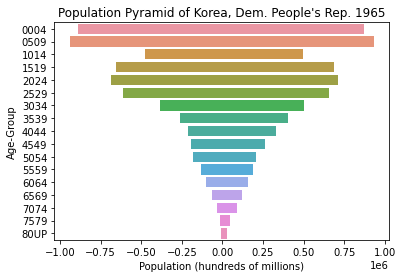

In [59]:
pop_pyramid(nk_1965)

(<AxesSubplot:title={'center':"Population Pyramid of Korea, Dem. People's Rep. 1975"}, xlabel='Population (hundreds of millions)', ylabel='Age-Group'>,
 <AxesSubplot:title={'center':"Population Pyramid of Korea, Dem. People's Rep. 1975"}, xlabel='Population (hundreds of millions)', ylabel='Age-Group'>)

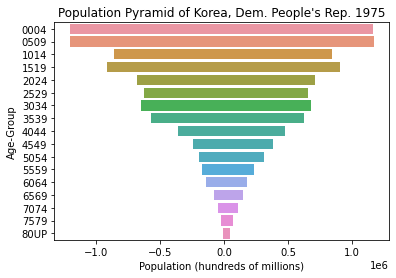

In [60]:
pop_pyramid(nk_1975)

### 1993 vs. 2000 Population Pyramids: Before and After Famine

<AxesSubplot:title={'center':"Population Pyramid of Korea, Dem. People's Rep. 1993"}, xlabel='Population (hundreds of millions)', ylabel='Age-Group'>

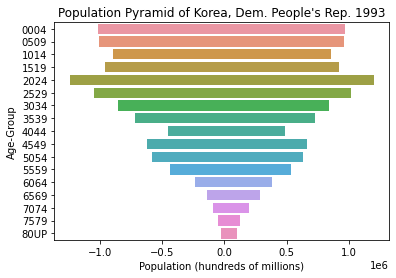

In [61]:
pop_pyramid(nk_1993)

<AxesSubplot:title={'center':"Population Pyramid of Korea, Dem. People's Rep. 2000"}, xlabel='Population (hundreds of millions)', ylabel='Age-Group'>

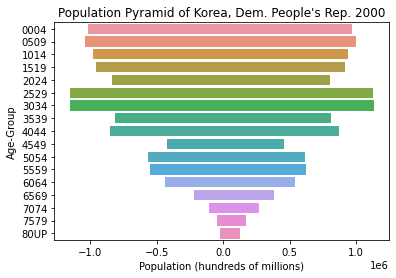

In [62]:
pop_pyramid(nk_2000)

## Late 1980s Fall & Collapse of Soviet Union Further Set up Conditions for Famine 

While multiple factors went into the buildup of North Korea's susceptibility of food shortages and widespread famine that would occur in the 1990s, one of the major global events that shifted that nation towards this was the collapse of the Soviet Union. This led to reduced agricultural inputs, materials, and fuel coming in from the Soviet Union and essential to sustain the inefficient farming systems that were existing in North Korea. This reduced inflow of inputs restrained agricultural output and would soon lead to the nation's inability to sufficiently meet the needs of that nation's population that largely expanded in the decades leading up. (Ireson, 2018)

## The 1990s Food Shortages and Famine:

The final series of events that took this weakened agricultural system into disarray was a progression of drought and severly destructive flooding in the early-mid 1990s. These climate events tumbled the nation into food shortages, widespread malnourishment, stunted growth, and fatal starvation over the mid-late 1990s with impacts that are still being felt to this day.

By the beginning of the 2000s, around half of the population did not have sufficient food. With one third of children displaying stunted growth. (Central Bureau of Statistics Institute of Child Nutrition Democratic People’s Republic of Korea, 2005)

Estimates of death toll corresponding to the famine are widespread in their estimates ranging from a quarter million upwards to 2 millions deaths. These numbers vary drastically in their values as to how and what deaths are attributed directly to the famine, with many other health and illnesses that are impacted by famine. Some of these numbers may also reflect the “forgone” population numbers that are a result of reduced fertility. (Haggard & Noland, 2009)

**Data Resources:**

See https://www.ers.usda.gov/data-products/international-agricultural-productivity/.

Data on TFP, output, factor use, and factor shares can be found at https://docs.google.com/spreadsheets/d/1DLn9owcS7ggojJGWlI9vKSz0hqozn6cbcqNGWgzMZ8k, which is publicly readable.

`eep153_tools`

In [63]:
!pip install eep153_tools
!pip install python_gnupg

from eep153_tools.sheets import decrypt_credentials
decrypt_credentials('students.json.gpg')

  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.4.8-py2.py3-none-any.whl (18 kB)
Input secret passphrase for students.json.gpg to create google drive credentials: noodle octopus


To check that this worked, the following gives a list of
emails for &ldquo;service<sub>accounts</sub>&rdquo; that now have credentials&#x2013;you can
then &ldquo;share&rdquo; google sheets with these.


In [64]:
!ls ~/.eep153.service_accounts/

students@eep153.iam.gserviceaccount.com


In [65]:
from eep153_tools.sheets import read_sheets

#### Read a bunch of google worksheets into a dictionary of dataframes
data = read_sheets('https://docs.google.com/spreadsheets/d/1DLn9owcS7ggojJGWlI9vKSz0hqozn6cbcqNGWgzMZ8k',force_numeric=False)

data.keys()

Key available for students@eep153.iam.gserviceaccount.com.


dict_keys(['Explanation', 'Ag TFP', 'Output', 'Inputs', 'Factor Shares', 'Ag Land', 'Land Weights', 'Cropland', 'Irrig', 'Pasture', 'Labor', 'Livestock', 'Machinery', 'Fertilizer', 'Feed'])

### Visualizing data on agricultural production:

In [69]:
def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

df = pd.DataFrame(D)


PRK = df.xs('PRK',level='WDI Code').dropna(how='any')

select = np.log(PRK)
select.iplot(title='Log North Korea Inputs & Output')

### Analysis of North Korea inputs and outputs:

In 1995 (the year the famine hit North Korea) you can see significant drop in the following inputs: feed, fertilizer, livestock as well as output.

## Summary Conclusion

The 1990s Famine of North Korea was not an isolated event but was built up to as a result of government policies, global events, and unpredictable weather disasters that led up to the conditions allowing for a famine. 

Beginning with mass urban industrialization policies through 60s and 70s which massively raised urban populations. North Korea’s focus on manufacturing gave rise to declining agricultural independence, and their food production became more susceptible to shortages.

The fall of the Soviet Union highly impacted the amount of agricultural resources available to North Korea.

## References

* Central Bureau of Statistics Institute of Child Nutrition Democratic People’s Republic of Korea. (n.d.). (rep.). DPRK 2004 Nutrition Assessment Report of Survey Results . February 2005. 


* Department of the Army. (1994, January 1). Pam 550-81 North Korea: A Country Study, 4th edition : Department of the army . Internet Archive. Retrieved February 9, 2022, from https://archive.org/details/PAM550-81 


* Encyclopædia Britannica, inc. (n.d.). Economy of North Korea: Agriculture, forestry, and fishing. Encyclopædia Britannica. Retrieved February 9, 2022, from https://www.britannica.com/place/North-Korea/Economy 


* First base/reference source of background information: Wikipedia:  Economy of North Korea. https://en.wikipedia.org/wiki/Economy_of_North_Korea#Manufacturing 


* Haggard, S., & Noland, M. (2009). Famine in North Korea: Markets, aid, and reform. Columbia University Press. 


* Ireson, Randall. (2018). Food Security in North Korea: Designing Realistic Possibilities. Shorenstein Asia-Pacific Research Center (APARC), 665–666. https://doi.org/https://web.archive.org/web/20150904004856/http://fsi-media.stanford.edu/evnts/4140/Ireson_FoodSecurity_2006.pdf  

